# Úkol č. 2 - Využití neuronových sítí

  * **Deadline je 13. 5. 2024, 23:59:59**, pokud odevzdáte úkol do 20. 5. 2024, 23:59:59, budete penalizování -12 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu musíte sestrojit vhodný model neuronové sítě pro vícetřídou klasifikaci.
  * Část bodů získáte za správné vypracování a část bodů získáte za výslednou přesnost Vašeho modelu na evaluačních datech.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 32x32 pixelů ve stupních šedi, které byly nějakým způsobem vyrobeny z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování (max 18 bodů)

**Body zadání**, za jejichž (poctivé) vypracování získáte **18 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Sestrojte a natrénujte několik variant modelu dopředné neuronové sítě. Přitom v rámci výpočetních možností:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Experimentujte s různými hloubkami a velikosmi vrstev.
      * Experimentujte se standardizací/normalizací dat.
      * Experimentujte s různými optimalizačními metodami.
      * Experimentujte s různými regularizačními technikami.
      * Získané výsledky vždy řádně okomentujte.

  * Sestrojte model konvoluční neuronové sítě. Přitom v rámci výpočetních možností:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Experimentujte s různými hloubkami a velikosmi vrstev.
      * Experimentujte se standardizací/normalizací dat.
      * Experimentujte s různými optimalizačními metodami.
      * Experimentujte s různými regularizačními technikami.
      * Získané výsledky vždy řádně okomentujte.
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici.
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do sloupce **label** a identifikátory do sloupce **ID**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
   * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,label
0,0
1,1
...
```

## Vyhodnocovací část (max 7 bodů)
Za přesnost (accuraccy) na odevzdaných predikcích pro vyhodnocovací množnu získáte dalších max **7 bodů**.

Označíme-li $A$ přesnost, které jste dosáhli, zaokrouhlenou na 2 desetinná místa, akumulují se výsledné body podle následujících pravidel:
* pokud $A \geq 0.80$ obdržíte +1 bod
* pokud $A \geq 0.83$ obdržíte +1 bod
* pokud $A \geq 0.86$ obdržíte +1 bod
* pokud $A \geq 0.87$ obdržíte +1 bod
* pokud $A \geq 0.88$ obdržíte +1 bod
* pokud $A \geq 0.89$ obdržíte +1 bod
* pokud $A \geq 0.90$ obdržíte +1 bod

**Příklad:** Pokud bude Vaše přesnost 0.856, vyjde A = 0.86 a vy získáte 3 body.


## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

In [29]:
import pandas as pd
import numpy as np
import os, copy
from IPython.display import display
from sklearn.model_selection import train_test_split, ParameterGrid
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.tensorboard import SummaryWriter
import torch
from torch.utils.data import DataLoader
from torch import nn
import random
from datetime import datetime

from tqdm import tqdm

import matplotlib.pyplot as plt

In [30]:
random_seed = 42


def set_random_seed(random_seed):
    """
    Function to set up random seed to be fixed, so we have consistent results
    """
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)


set_random_seed(random_seed)

# exploring the environment of the host, if the use of graphics card is available.
print("CUDA Available: ", torch.cuda.is_available())
print("cuDNN Enabled: ", torch.backends.cudnn.enabled)
print("cuDNN Version: ", torch.backends.cudnn.version())

# set up to use deterministic algorithms, so we have consistent results
torch.backends.cudnn.deterministic = True

CUDA Available:  True
cuDNN Enabled:  True
cuDNN Version:  8700


# Data Exploration

We will start with exploration of our data. 

From given dataset [description](https://www.kaggle.com/datasets/zalando-research/fashionmnist), we know:
- Our dataset is a set of images in shades of grey (meaning we have only one channel). 
- Image size is $32 \times 32$. 
- Each image is represented as a row of pixels with a label column.

Label column has following classes:

- 0 - T-shirt/top
- 1 - Trouser
- 2 - Pullover
- 3 - Dress
- 4 - Coat
- 5 - Sandal
- 6 - Shirt
- 7 - Sneaker
- 8 - Bag
- 9 - Ankle boot

In [76]:
# for visualization purposes later 
labels_dict = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt",
               7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

In [9]:
df_data = pd.read_csv('train.csv')

From the beginning we will split dataset into train and validation parts, exploring and analyzing data only of the train part. 

In [10]:
def split_data(data):
    """
    Split dataset into training and validation parts
    """
    print(f'Data shape: {data.shape}')
    labels = data['label']
    images = data.drop('label', axis=1)
    print(f'Images data shape: {images.shape}')
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.4, random_state=random_seed)
    print(f"Train shape: {X_train.shape}")
    print(f"Validation shape: {X_val.shape}")
    return X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = split_data(df_data)

Data shape: (52500, 1025)
Images data shape: (52500, 1024)
Train shape: (31500, 1024)
Validation shape: (21000, 1024)


We have high dimensionality data - $1024$ dimensions. For neural networks high dimensionality is not a concern, but a lack of data can be. In our case we have quite a lot of images - $52500$ in the whole dataset, which should be quite enough. 

Now for exploration purposes, we will look at some rows and columns of raw data: 

In [30]:
def explore_with_m_rd_columns(m=5):
    """Choose random m columns and drop the rest except label column"""
    data_train_df = pd.concat((y_train, X_train), axis=1)
    random_indices = np.random.choice(range(1, data_train_df.shape[1]), m, replace=False)
    selected_indices = np.append(0, random_indices)
    selected_df = data_train_df.iloc[:, selected_indices]
    return selected_df


selection = explore_with_m_rd_columns(5)
selection.head()

,label,pix526,pix358,pix445,pix32,pix619
2262,3,176,2,2,2,190
25445,4,211,4,4,4,223
46043,7,201,0,0,0,220
12531,0,179,3,3,3,183
10152,5,204,80,0,0,31


In [31]:
selection.describe()

,label,pix526,pix358,pix445,pix32,pix619
count,31500.000000,31500.000000,31500.000000,31500.000000,31500.000000,31500.000000
mean,4.526444,147.596952,20.319365,6.203841,0.886762,115.607302
std,2.867504,71.149515,50.248750,25.342137,1.499157,83.160125
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,99.000000,0.000000,0.000000,0.000000,30.000000
50%,5.000000,164.000000,0.000000,0.000000,0.000000,124.000000
75%,7.000000,205.000000,4.000000,2.000000,1.000000,191.000000
max,9.000000,255.000000,255.000000,255.000000,11.000000,255.000000


In [32]:
selection.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31500 entries, 2262 to 15795
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   31500 non-null  int64
 1   pix526  31500 non-null  int64
 2   pix358  31500 non-null  int64
 3   pix445  31500 non-null  int64
 4   pix32   31500 non-null  int64
 5   pix619  31500 non-null  int64
dtypes: int64(6)
memory usage: 1.7 MB


Pixels are given as integers. Using Pytorch, we will need float datatypes, so we will later convert the integers to floats, except label column, where integer type can be left.

In [33]:
np.sort(y_train.unique())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

We see that in training data there are $10$ unique labels, thus all classes are present.

We will look now at $10$ random images from dataset for each class to visualize what our classes are.

In [34]:
# for each class find one row with that class
indices = list()
for label in np.sort(y_train.unique()):
    indices.append(y_train[y_train == label].index[0])

# data with selected indices
selection_X_train, selection_y_train = X_train.loc[indices], y_train.loc[indices]

In [77]:
def draw_images(images, labels, shape, scale=1):
    """Draw images in a grid with a given shape. Scale it to make the visualization bigger."""
    images = images.to_numpy()
    labels = labels.to_numpy()

    fig = plt.figure(figsize=(scale * 2 * shape[1], scale * 2 * shape[0]), constrained_layout=True)
    i = 0
    while i < images.shape[0]:
        ax_hist = fig.add_subplot(2 * shape[0], 2 * shape[1], 2 * i + 1)
        ax_hist.hist(images[i], bins=256)
        ax_hist.set_yscale('log')
        ax_hist.set_ylabel("Count (log scale)")
        ax_hist.set_xlabel("Pixel value")

        ax_image = fig.add_subplot(2 * shape[0], 2 * shape[1], 2 * i + 2, xticks=[], yticks=[])
        image = images[i].reshape((32, 32))
        ax_image.imshow(image, cmap="Oranges", interpolation="nearest")
        ax_image.set_title(f"{labels_dict[i]}\n(Y = {labels[i]})")

        i += 1

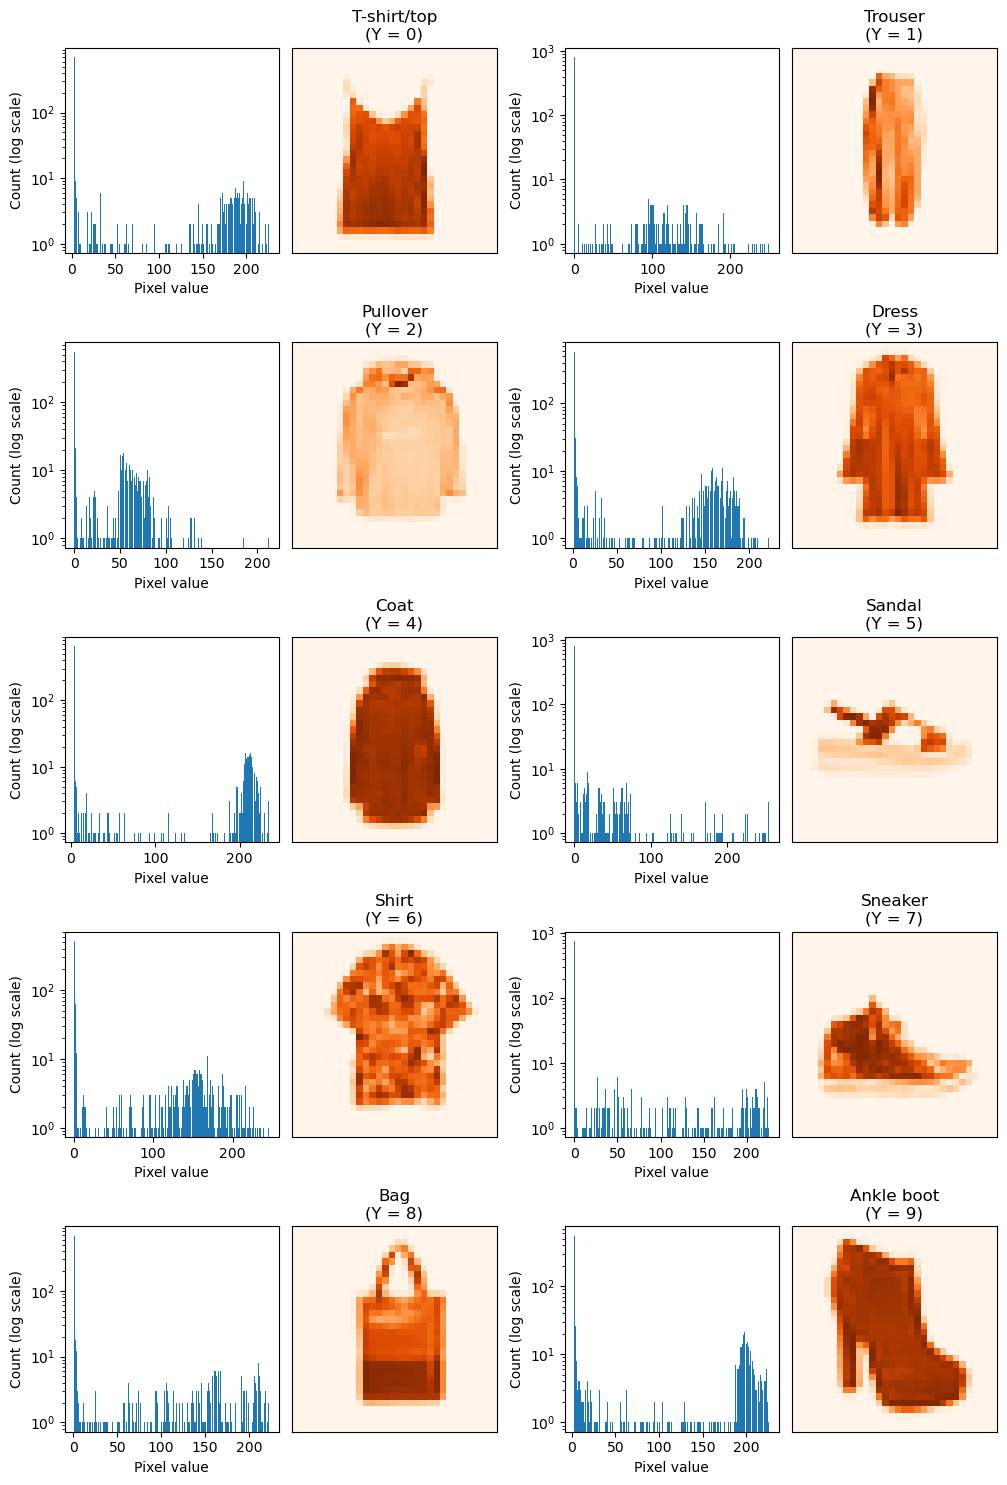

In [36]:
draw_images(selection_X_train, selection_y_train, shape=(5, 2), scale=2.5)

Visualization shows not only the images, but their histograms too - how many pixels of each value are present in the image.

Now we will also look at how classes are distributed, if they are balanced.

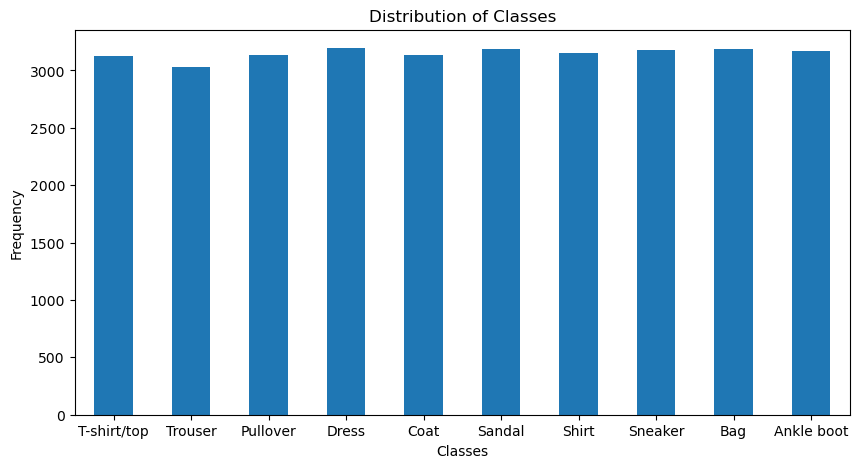

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
class_counts = y_train.value_counts().sort_index()
class_counts.plot(ax=ax, kind='bar')
ax.set_title("Distribution of Classes")
ax.set_xlabel("Classes")
ax.set_ylabel("Frequency")
ax.set_xticks(class_counts.index, labels=labels_dict.values(), rotation=0)
plt.show()

We see that classes are distributed almost uniformly, so we don't have to be concerned with data imbalance issues.

In [38]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52500 entries, 0 to 52499
Columns: 1025 entries, pix1 to label
dtypes: int64(1025)
memory usage: 410.6 MB


To store the dataset in memory takes $410.6$ MB, which is high, but tolerable.

We will create torch datasets from our splits and convert it to float32 data type, because by default models will have weights with float32 data type.

In [11]:
train_data = torch.utils.data.TensorDataset(torch.tensor(X_train.to_numpy(), dtype=torch.float32),
                                            torch.tensor(y_train.to_numpy()))
val_data = torch.utils.data.TensorDataset(torch.tensor(X_val.to_numpy(), dtype=torch.float32),
                                          torch.tensor(y_val.to_numpy()))

# Feed Forward Neural Network

Now we will train a feed forward neural network using pytorch api. Neural networks show themselves good with highly dimensional data with a lot of datapoints. In our case we have a lot of data, so neural network should show itself as quite good model.

## Preparations

We will use Pytorch dataloaders to split our samples into batches (or minibatches) for training. 

In [13]:
training_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

train_features, train_labels = next(iter(training_loader))
print(f"Features batch shape: {train_features.size()}; data type: {train_features.dtype}")
print(f"Labels batch shape: {train_labels.size()}; data type: {train_labels.dtype}")

Features batch shape: torch.Size([32, 1024]); data type: torch.float32
Labels batch shape: torch.Size([32]); data type: torch.int64


We know that input size and output size will not change (we will not use dimensionality reduction techniques), so we will make them constant.

In [14]:
INPUT_SIZE = 1024
OUTPUT_SIZE = 10

### Logging


To analyze our results, we will save results in csv file, so we can later analyze it with Pandas, and we will save our results in tensorboard logs, to see visualizations in tensorboard.
For this we need to prepare certain classes and functions.

In [60]:
def parse_hyperparameters(hparams):
    """Produces a short string for logging purposes which displays 
    used hyperparameters and their values in a shortened form"""
    parsed_items = []

    for hparam, value in hparams.items():
        short_hparam = ''.join([word[0] for word in hparam.split('_')])
        parsed_item = f"{short_hparam}={value}"
        parsed_items.append(parsed_item)

    result_string = ','.join(parsed_items)
    return result_string

In [69]:
class CSVExporter:
    """
    Class that aggregates training results for each epoch, 
    and after training all epochs appends results to results.csv file in logging directory.
    """

    def __init__(self, hparams_columns):
        self.scalars = {column: list() for column in
                        ["log_name", "tag"] + hparams_columns + ["train_loss", "train_acc", "val_loss", "val_acc"]}
        self.log_name = None
        self.tag = None
        self.save_path = None

    def init(self, log_name, tag, log_dir):
        self.log_name = log_name
        self.tag = tag
        self.save_path = f"{log_dir}/results.csv"

    def add_scalars(self, hparams, train_loss, train_acc, val_loss, val_acc, epoch):
        self.scalars["epochs"].append(epoch)
        self.scalars["train_loss"].append(train_loss)
        self.scalars["train_acc"].append(train_acc)
        self.scalars["val_loss"].append(val_loss)
        self.scalars["val_acc"].append(val_acc)
        self.scalars['log_name'].append(self.log_name)
        self.scalars['tag'].append(self.tag)

        for k_hparam, v_hparam in hparams.items():
            self.scalars[k_hparam].append(v_hparam)

    def save(self):
        df_scalars = pd.DataFrame(self.scalars)
        if os.path.exists(self.save_path):
            df_existing = pd.read_csv(self.save_path, index_col=False)
            df_scalars = pd.concat([df_existing, df_scalars], ignore_index=True)
        df_scalars.to_csv(path_or_buf=self.save_path, index=False)


In [85]:
class Writer:
    """
    Class used to save results in tensorboard and add new scalars to CSVExporter if the exporter is given.
    """

    def __init__(self, log_dir, tag, hparams, print_summary, csv_exporter=None):
        if tag:
            log_path = f"{log_dir}/{tag}"

        current_time = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
        hparams_string = parse_hyperparameters(hparams)
        log_name = f"{current_time}_{hparams_string}"

        self.train_writer = SummaryWriter(log_dir=f"{log_path}/{log_name}/train")
        self.val_writer = SummaryWriter(log_dir=f"{log_path}/{log_name}/val")

        self.hparams = copy.deepcopy(hparams)
        del self.hparams['epochs']

        self.csv_exporter = csv_exporter
        if csv_exporter:
            csv_exporter.init(log_name, tag, log_dir)

        if print_summary:
            print(f"Current model hyperparameters: {hparams_string}")

    def add_scalars(self, train_loss, train_acc, val_loss, val_acc, epoch):
        self.train_writer.add_scalar(tag=f"Loss/train", scalar_value=train_loss, global_step=epoch)
        self.train_writer.add_scalar(tag=f"Accuracy/train", scalar_value=train_acc, global_step=epoch)

        self.train_writer.add_scalar(tag=f"Loss", scalar_value=train_loss, global_step=epoch)
        self.train_writer.add_scalar(tag=f"Accuracy", scalar_value=train_acc, global_step=epoch)

        self.val_writer.add_scalar(tag=f"Loss/validation", scalar_value=val_loss, global_step=epoch)
        self.val_writer.add_scalar(tag=f"Accuracy/validation", scalar_value=val_acc, global_step=epoch)

        self.val_writer.add_scalar(tag=f"Loss", scalar_value=val_loss, global_step=epoch)
        self.val_writer.add_scalar(tag=f"Accuracy", scalar_value=val_acc, global_step=epoch)

        if self.csv_exporter:
            self.csv_exporter.add_scalars(self.hparams, train_loss, train_acc, val_loss, val_acc, epoch)


### Training functions

We will define functions to train a neural network model.

In [54]:
def train_epoch(model, train_loader, optimizer, loss_fn, disable_output):
    """
    Train one epoch for a model.
    Computes training loss and accuracy while epoch training.
    """
    epoch_cum_loss = 0
    epoch_cum_correct = 0

    for batch in tqdm(train_loader, total=len(train_loader), disable=None if disable_output else False):
        batch_features, batch_labels = batch
        optimizer.zero_grad()
        output_logits = model(batch_features)
        loss = loss_fn(output_logits, batch_labels)
        loss.backward()
        optimizer.step()

        # loss accumulation for report
        last_mean_loss = loss.item()
        epoch_cum_loss += last_mean_loss * batch_features.shape[0]

        # accuracy accumulation for report
        with torch.no_grad():
            batch_probabilities = torch.softmax(input=output_logits, dim=1)
        batch_predictions = batch_probabilities.argmax(dim=1)
        correct = (batch_predictions == batch_labels).sum()
        epoch_cum_correct += correct

    return epoch_cum_loss, epoch_cum_correct


In [87]:
def validation(model, valid_loader, loss_fn):
    """
    Computes validation loss and accuracy score without any training, gradients are disabled.
    """
    epoch_cum_loss = 0
    epoch_cum_correct = 0

    for batch in valid_loader:
        batch_features, batch_labels = batch

        with torch.no_grad():
            output_logits = model(batch_features)
            loss = loss_fn(output_logits, batch_labels)
            batch_probabilities = torch.softmax(input=output_logits, dim=1)

        # loss accumulation for report
        last_mean_loss = loss.item()
        epoch_cum_loss += last_mean_loss * batch_features.shape[0]

        # accuracy accumulation for report
        batch_predictions = batch_probabilities.argmax(dim=1)
        correct = (batch_predictions == batch_labels).sum()
        epoch_cum_correct += correct
    return epoch_cum_loss, epoch_cum_correct


In [160]:
def get_optimizer(model, **hparams):
    optimizer_params = {
        "params": model.parameters(),
        "weight_decay": hparams['weight_decay'] if 'weight_decay' in hparams else 0.0
    }

    optimizer = None

    if "optimizer" not in hparams:
        optimizer = torch.optim.Adam(**optimizer_params)
    else:
        if hparams['optimizer'] == 'Adam':
            optimizer = torch.optim.Adam(**optimizer_params)
        elif hparams['optimizer'] == 'SGD':
            optimizer = torch.optim.SGD(**optimizer_params)
    return optimizer

In [154]:
def train(model, train_data, val_data,
          tag=None,
          csv_exporter=None,
          disable_output=False,
          print_summary=True,
          **hparams):
    """
    Trains instantiates a given model class, passing to it hyperparameters and then proceeds
    starts training, logging the results for each epoch.
    """
    set_random_seed(random_seed)

    model = model(**hparams)

    if print_summary:
        print(model)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=hparams['batch_size'], shuffle=True)
    validation_loader = torch.utils.data.DataLoader(val_data, batch_size=hparams['batch_size'], shuffle=True)

    optimizer = get_optimizer(model, **hparams)

    loss_fn = torch.nn.CrossEntropyLoss(
        label_smoothing=hparams['label_smoothing'] if 'label_smoothing' in hparams else 0.0
    )

    writer = Writer("logs", tag, hparams=hparams, print_summary=print_summary, csv_exporter=csv_exporter)

    for epoch in range(hparams['epochs']):
        model.train(True)
        epoch_cum_loss, epoch_cum_correct = train_epoch(model, train_loader, optimizer, loss_fn, disable_output)
        model.train(False)

        train_loss = epoch_cum_loss / len(train_data)
        train_accuracy = epoch_cum_correct / len(train_data)

        train_report = f"train loss: {train_loss:.3f}, train accuracy: {train_accuracy:.3f}"

        val_epoch_cum_loss, val_epoch_cum_correct = validation(model, validation_loader, loss_fn)
        val_loss = val_epoch_cum_loss / len(val_data)
        val_accuracy = val_epoch_cum_correct / len(val_data)

        val_report = f"validation loss: {val_loss:.3f}, validation accuracy: {val_accuracy:.3f}"

        writer.add_scalars(train_loss=train_loss, train_acc=train_accuracy.item(),
                           val_loss=val_loss, val_acc=val_accuracy.item(),
                           epoch=epoch + 1)

        if not disable_output:
            print(f"EPOCH: {epoch + 1}, {train_report}, {val_report}")

### Neural Network Model Class

In [122]:
class NeuralNetwork(nn.Module):
    """
    Simple Feed-Forward Neural Network with fixed ReLu activation function. 
    """

    def __init__(self, input_size=INPUT_SIZE, output_size=OUTPUT_SIZE, **hparams):
        super().__init__()

        # container for layers
        self.sequential = nn.Sequential()

        # add at least one hidden layer and activation
        self.sequential.append(nn.Linear(in_features=input_size, out_features=hparams['hidden_size']))
        self.sequential.append(nn.ReLU())
        if 'dropout' in hparams:
            self.sequential.append(nn.Dropout(p=hparams['dropout']))

        # add any additional hidden layers to the model if any
        for _ in range(1, hparams['hidden_layers']):
            self.sequential.append(nn.Linear(in_features=hparams['hidden_size'], out_features=hparams['hidden_size']))
            self.sequential.append(nn.ReLU())
            if 'dropout' in hparams:
                self.sequential.append(nn.Dropout(p=hparams['dropout']))

        # add end layer
        self.sequential.append(nn.Linear(in_features=hparams['hidden_size'], out_features=output_size))

    def forward(self, x):
        return self.sequential(x)

## Model fine-tuning

Now we will start training our model. Because training of neural network is computationally an intensive task, we will first experiment with different hidden layers number, layer sizes, batch sizes. After that we will analyze for which hyperparameters values we had best scores, reduce our hyperparameter space to those top hyperparameters and then proceed with experimenting with new hyperparameters. 

Let's try some random model to see how our training process works:

In [123]:
hyperparameters = {"hidden_size": 64,
                   "hidden_layers": 3,
                   "epochs": 5,
                   "batch_size": 64}

csv_exporter = CSVExporter(list(hyperparameters.keys()))

train(model=NeuralNetwork,
      train_data=train_data, val_data=val_data,
      tag="test", csv_exporter=csv_exporter,
      **hyperparameters)

csv_exporter.save()

NeuralNetwork(
  (sequential): Sequential(
    (0): Linear(in_features=1024, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)
Current model hyperparameters: hs=64,hl=3,e=5,bs=64


100%|██████████| 493/493 [00:01<00:00, 369.71it/s]


EPOCH: 1, train loss: 0.882, train accuracy: 0.693, validation loss: 0.649, validation accuracy: 0.751


100%|██████████| 493/493 [00:01<00:00, 403.30it/s]


EPOCH: 2, train loss: 0.626, train accuracy: 0.771, validation loss: 0.647, validation accuracy: 0.763


100%|██████████| 493/493 [00:01<00:00, 380.38it/s]


EPOCH: 3, train loss: 0.572, train accuracy: 0.789, validation loss: 0.558, validation accuracy: 0.801


100%|██████████| 493/493 [00:01<00:00, 390.00it/s]


EPOCH: 4, train loss: 0.545, train accuracy: 0.800, validation loss: 0.553, validation accuracy: 0.796


100%|██████████| 493/493 [00:01<00:00, 381.56it/s]


EPOCH: 5, train loss: 0.515, train accuracy: 0.807, validation loss: 0.533, validation accuracy: 0.805


### Experimentation with depth and unit size

Now, lets experiment with hidden layer sizes and number of hidden layers:

In [74]:
hparams = {
    "hidden_size": [32, 64, 128, 256],
    "hidden_layers": range(1, 5),
    "epochs": [20],
    "batch_size": [32, 128, 512, 2048, 8192]
}
hparams_grid = ParameterGrid(hparams)
print("Hyperparameter space size: ", len(hparams_grid))


Hyperparameter space size:  80


In [86]:
for params in tqdm(hparams_grid, total=len(hparams_grid)):
    csv_exporter = CSVExporter(list(hparams.keys()))
    train(NeuralNetwork, train_data, val_data, tag="depth_and_size_experimentation", disable_output=True,
          print_summary=False, csv_exporter=csv_exporter, **params)
    csv_exporter.save()

100%|██████████| 80/80 [38:58<00:00, 29.23s/it]  


Now we will explore results and try to get some useful insights.

First we will look at Tensorboard. To use tensorboard we run in the shell `tensorboard --log_dir=logs/depth_and_size_experimentation` to see visualizations of training results.

![](images/depth_size_exp/all_rd_42.png)

This gives us a broad picture of the training.

The `Accuracy` and `Loss` plots without `train` or `validation` suffixes show both train and validation results on the same plot, while plots with suffixes show `train` and `validation` separately. Still this is a big mess.

Generally we see that $20$ epochs is a point where the validation score almost stops improving much or even for some hyperparameters starts to worsen (over-fitting).

Another interesting detail - while training score os quite smooth (mostly), validation score is quite spiky, which may imply that after each gradient step we encounter some "wall" in parameter space:

![](images/parameter_space_spikes.png)
Deep Learning Book, Goodfellow


Now we will find the best hyperparameters and also look at top of best models to see which hyperparameters were best in general.

In [89]:
df_results = pd.read_csv('logs/results.csv')
df_depth_size_exp = df_results[df_results['tag'] == 'depth_and_size_experimentation']
df_depth_size_exp.head()

,log_name,tag,hidden_size,hidden_layers,epochs,batch_size,train_loss,train_acc,val_loss,val_acc
0,"2024-05-13_13:42:13_bs=32,e=20,hl=1,hs=32",depth_and_size_experimentation,32,1,1,32,1.904417,0.353714,1.447754,0.445429
1,"2024-05-13_13:42:13_bs=32,e=20,hl=1,hs=32",depth_and_size_experimentation,32,1,2,32,1.291896,0.499206,1.210513,0.541762
2,"2024-05-13_13:42:13_bs=32,e=20,hl=1,hs=32",depth_and_size_experimentation,32,1,3,32,1.058130,0.605905,0.966570,0.654952
3,"2024-05-13_13:42:13_bs=32,e=20,hl=1,hs=32",depth_and_size_experimentation,32,1,4,32,0.914417,0.662381,0.869516,0.678476
4,"2024-05-13_13:42:13_bs=32,e=20,hl=1,hs=32",depth_and_size_experimentation,32,1,5,32,0.883898,0.667778,0.968250,0.636000


In [90]:
best_model_index = df_depth_size_exp['val_loss'].idxmin()
df_depth_size_exp.loc[best_model_index]

log_name         2024-05-13_14:15:16_bs=2048,e=20,hl=4,hs=256
tag                            depth_and_size_experimentation
hidden_size                                               256
hidden_layers                                               4
epochs                                                     15
batch_size                                               2048
train_loss                                           0.334701
train_acc                                            0.875778
val_loss                                             0.442879
val_acc                                               0.84581
Name: 1274, dtype: object

We see that the best validation loss score is $\approx 0.443$ in epoch $15$:

![](images/depth_size_exp/best_model_loss.png)

The best accuracy $\approx 0.849$ is in epoch $19$:

![](images/depth_size_exp/best_model_acc.png)


Now we will try to guess best hyperparameters for this task by looking on top models, which hyperparameters they have.

Before that we can say:
- more hidden layers and units we have, the better is our model's capacity to solve the task, though very high capacity may lead to overfitting.
- more layers makes neural network much harder to train, because of computational load and vanishing/exploding gradients.
- large batch size may speed up training process significantly, if we have enough memory to store the whole batch, and smaller batch sizes lead to better generalization, because of some noise introduced by a smaller subset of data.

In [107]:
# consider all models with value accuracy higher than certain limit
df_dse_top = df_depth_size_exp[df_depth_size_exp['val_acc'] >= 0.83]
df_dse_top.describe()

,hidden_size,hidden_layers,epochs,batch_size,train_loss,train_acc,val_loss,val_acc
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,206.147368,3.547368,15.673684,652.463158,0.343992,0.871130,0.480604,0.836223
std,66.784660,0.631924,3.193884,725.299378,0.038422,0.013959,0.020569,0.004348
min,64.000000,2.000000,6.000000,32.000000,0.260462,0.834095,0.442879,0.830048
25%,128.000000,3.000000,13.000000,128.000000,0.316346,0.860921,0.466400,0.833357
50%,256.000000,4.000000,16.000000,512.000000,0.344777,0.871016,0.479666,0.835619
75%,256.000000,4.000000,18.000000,512.000000,0.374269,0.881746,0.493571,0.838619
max,256.000000,4.000000,20.000000,2048.000000,0.442382,0.902825,0.531887,0.849190


We see some important information here, for example withing top models, what were mean values of hyperparameters.
 
But let's see actual distributions:

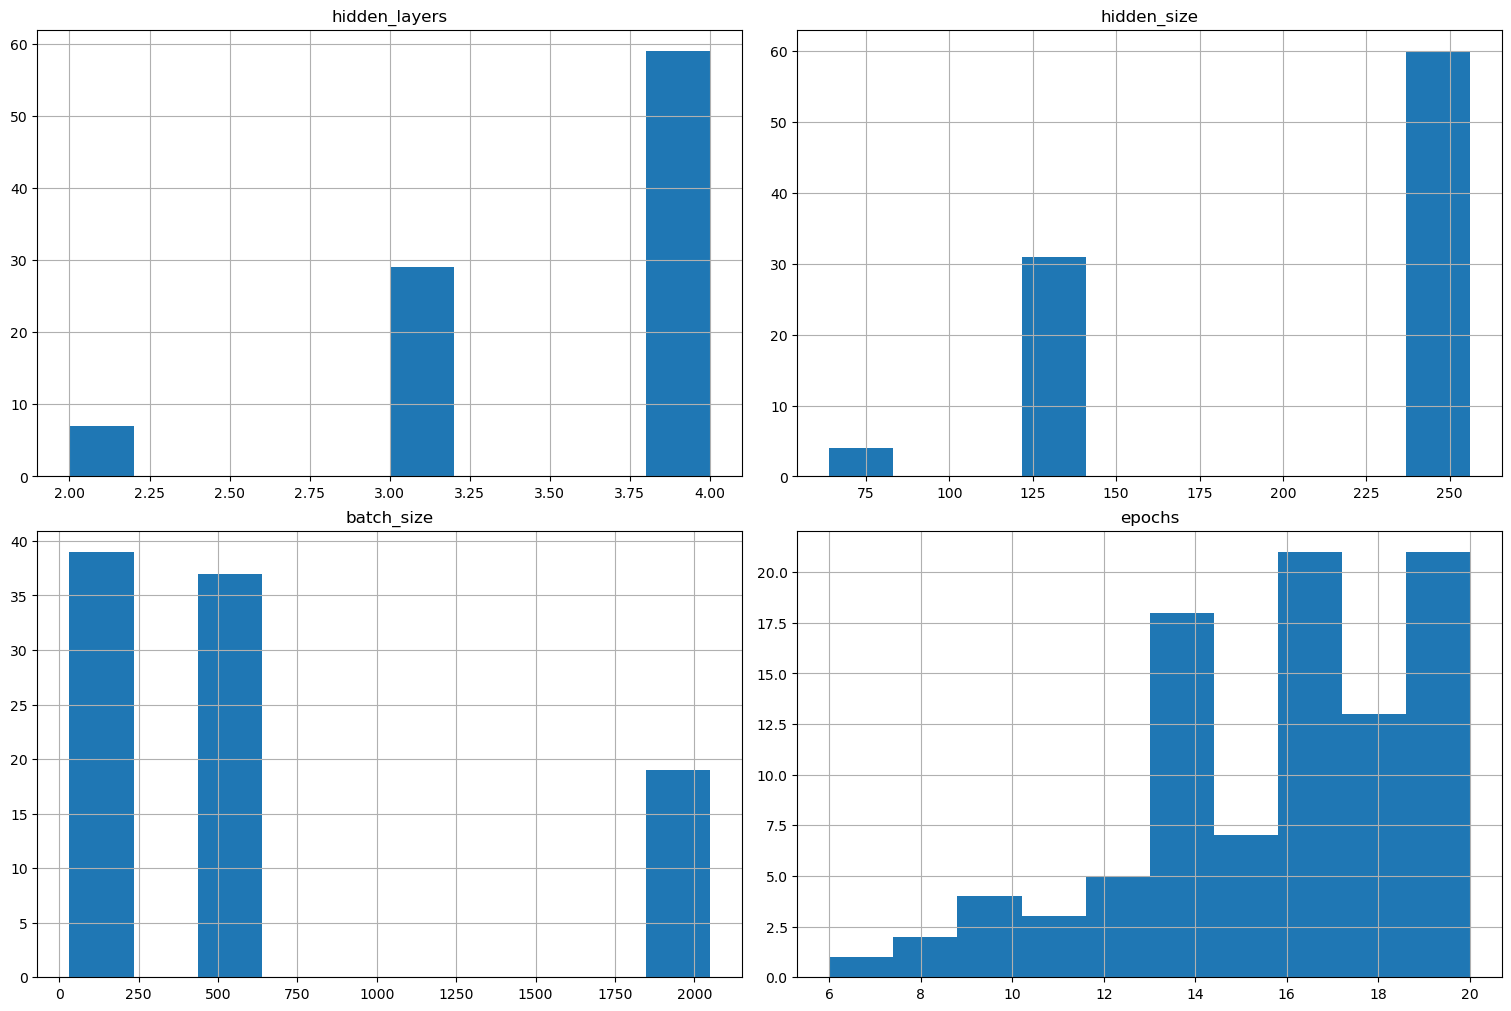

In [120]:
fig = plt.figure(figsize=(15, 10), constrained_layout=True)
params = ['hidden_layers', 'hidden_size', 'batch_size', 'epochs']
for i, param in enumerate(params):
    ax = fig.add_subplot(2, 2, i + 1)
    df_dse_top[param].hist(ax=ax)
    ax.set_title(param)

plt.show()

We see that we can constraint our hyperparameter space to:
- smaller batch sizes (32 - 512)
- more hidden layers (3-4)
- more hidden units (128 - 256)

Now we will proceed adding some regularization.

### Experimentation with regularization

For regularization we will try 3 hyperparameters:
- dropout - prevents overfitting, improving generalization. Disables a fraction of neurons.
- weight decay - L2 regularization of weights, same as in Linear Regression, but now we penalize all the weights in the model. This can prevent overfitting of the model.
- label smoothing - technique to reduce overfitting, making model less overconfident. If softens the distribution of label. This will allow some freedom to our model to predict correctly some images which can look similar to other classes.

In [161]:
hyperparameters = {
    "hidden_size": 256,
    "hidden_layers": 4,
    "epochs": 5,
    "batch_size": 256,
    "weight_decay": 1e-4,
    "label_smoothing": 0.1,
    "dropout": 0.1
}

csv_exporter = CSVExporter(list(hyperparameters.keys()))

train(model=NeuralNetwork,
      train_data=train_data, val_data=val_data,
      tag="test", csv_exporter=csv_exporter,
      **hyperparameters)

csv_exporter.save()

NeuralNetwork(
  (sequential): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=256, out_features=10, bias=True)
  )
)
Current model hyperparameters: hs=256,hl=4,e=5,bs=256,wd=0.0001,ls=0.1,d=0.1


100%|██████████| 124/124 [00:01<00:00, 93.50it/s] 


EPOCH: 1, train loss: 1.301, train accuracy: 0.656, validation loss: 1.086, validation accuracy: 0.751


100%|██████████| 124/124 [00:01<00:00, 98.95it/s] 


EPOCH: 2, train loss: 1.061, train accuracy: 0.763, validation loss: 0.991, validation accuracy: 0.787


100%|██████████| 124/124 [00:01<00:00, 103.26it/s]


EPOCH: 3, train loss: 1.010, train accuracy: 0.783, validation loss: 0.970, validation accuracy: 0.795


100%|██████████| 124/124 [00:01<00:00, 91.67it/s]


EPOCH: 4, train loss: 0.978, train accuracy: 0.800, validation loss: 0.957, validation accuracy: 0.797


100%|██████████| 124/124 [00:01<00:00, 97.77it/s]


EPOCH: 5, train loss: 0.962, train accuracy: 0.806, validation loss: 0.934, validation accuracy: 0.813


In [135]:
hparams = {
    "hidden_size": [128, 256],
    "hidden_layers": [3, 4],
    "epochs": [20],
    "batch_size": [256],
    "weight_decay": [0.0, 1e-4, 1e-2],
    "label_smoothing": [0.0, 0.1],
    "dropout": [0.0, 0.1, 0.3]
}
hparams_grid = ParameterGrid(hparams)
print("Hyperparameter space size: ", len(hparams_grid))

Hyperparameter space size:  72


In [136]:
for params in tqdm(hparams_grid, total=len(hparams_grid)):
    csv_exporter = CSVExporter(list(hparams.keys()))
    train(NeuralNetwork, train_data, val_data, tag="ffnn_regularization", disable_output=True,
          print_summary=False, csv_exporter=csv_exporter, **params)
    csv_exporter.save()

100%|██████████| 72/72 [37:47<00:00, 31.49s/it]


![](images/ffnn_regularization/all.png)

We can see that in validation loss there is a huge drop when label smoothing is used with $0.1$ value. This is a very interesting detail. By smoothing labels a lot of images are classified improperly. The reason may be that there are some images that have different labels, but are very similar visually, so when we make our model less confident about the label, it starts to predict poorly.

In [137]:
df_results = pd.read_csv('logs/results.csv')
df_fr = df_results[df_results['tag'] == 'ffnn_regularization']
df_fr.head()

,log_name,tag,hidden_size,hidden_layers,epochs,batch_size,train_loss,train_acc,val_loss,val_acc,weight_decay,label_smoothing,dropout
1610,"2024-05-13_16:59:46_bs=128,d=0.0,e=20,hl=3,hs=...",ffnn_regularization,128,3,1,128,0.902039,0.695238,0.688032,0.755667,0.0,0.0,0.0
1611,"2024-05-13_16:59:46_bs=128,d=0.0,e=20,hl=3,hs=...",ffnn_regularization,128,3,2,128,0.612404,0.775746,0.594963,0.778190,0.0,0.0,0.0
1612,"2024-05-13_16:59:46_bs=128,d=0.0,e=20,hl=3,hs=...",ffnn_regularization,128,3,3,128,0.565688,0.789587,0.561931,0.798429,0.0,0.0,0.0
1613,"2024-05-13_16:59:46_bs=128,d=0.0,e=20,hl=3,hs=...",ffnn_regularization,128,3,4,128,0.527441,0.805302,0.524727,0.809524,0.0,0.0,0.0
1614,"2024-05-13_16:59:46_bs=128,d=0.0,e=20,hl=3,hs=...",ffnn_regularization,128,3,5,128,0.477242,0.821968,0.623681,0.769095,0.0,0.0,0.0


In [140]:
best_model_index = df_fr['val_loss'].idxmin()
df_fr.loc[best_model_index]

log_name           2024-05-13_17:31:10_bs=256,d=0.1,e=20,hl=4,hs=...
tag                                              ffnn_regularization
hidden_size                                                      256
hidden_layers                                                      4
epochs                                                            15
batch_size                                                       256
train_loss                                                  0.415928
train_acc                                                   0.844127
val_loss                                                    0.445597
val_acc                                                     0.838333
weight_decay                                                  0.0001
label_smoothing                                                  0.0
dropout                                                          0.1
Name: 2709, dtype: object

Best model with regularization has validation loss $\approx 0.445$ and validation accuracy $\approx 0.838$.

![](images/ffnn_regularization/best_model_acc.png)
![](images/ffnn_regularization/best_model_loss.png)

Lets look now what is the best model overall:

In [141]:
best_model_index = df_results['val_loss'].idxmin()
df_results.loc[best_model_index]

log_name           2024-05-13_14:15:16_bs=2048,e=20,hl=4,hs=256
tag                              depth_and_size_experimentation
hidden_size                                                 256
hidden_layers                                                 4
epochs                                                       15
batch_size                                                 2048
train_loss                                             0.334701
train_acc                                              0.875778
val_loss                                               0.442879
val_acc                                                 0.84581
weight_decay                                                NaN
label_smoothing                                             NaN
dropout                                                     NaN
Name: 1274, dtype: object

We see that the use of dropout and weight decay in overall didn't improve results. Let's analyze top overall models:

In [143]:
# fill missing hyperparameters with 0.0
df_results.fillna(0.0)
# consider all models with value accuracy higher than certain limit
df_ffnn_overall_top = df_results.sort_values(by='val_loss').head(100)
df_ffnn_overall_top.describe()

,hidden_size,hidden_layers,epochs,batch_size,train_loss,train_acc,val_loss,val_acc,weight_decay,label_smoothing,dropout
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,56.000000,56.0,56.000000
mean,211.200000,3.580000,14.560000,608.000000,0.386133,0.855166,0.464846,0.834808,0.001643,0.0,0.055357
std,61.359678,0.535224,3.300811,687.588319,0.049641,0.018729,0.008455,0.005314,0.003690,0.0,0.050162
min,128.000000,2.000000,7.000000,128.000000,0.287839,0.817905,0.442879,0.823333,0.000000,0.0,0.000000
25%,128.000000,3.000000,12.000000,256.000000,0.346810,0.839754,0.460844,0.830833,0.000000,0.0,0.000000
50%,256.000000,4.000000,15.000000,256.000000,0.389839,0.853127,0.466658,0.834167,0.000100,0.0,0.100000
75%,256.000000,4.000000,17.000000,512.000000,0.426007,0.870643,0.471727,0.838333,0.000100,0.0,0.100000
max,256.000000,4.000000,20.000000,2048.000000,0.483391,0.892698,0.475816,0.849190,0.010000,0.0,0.100000


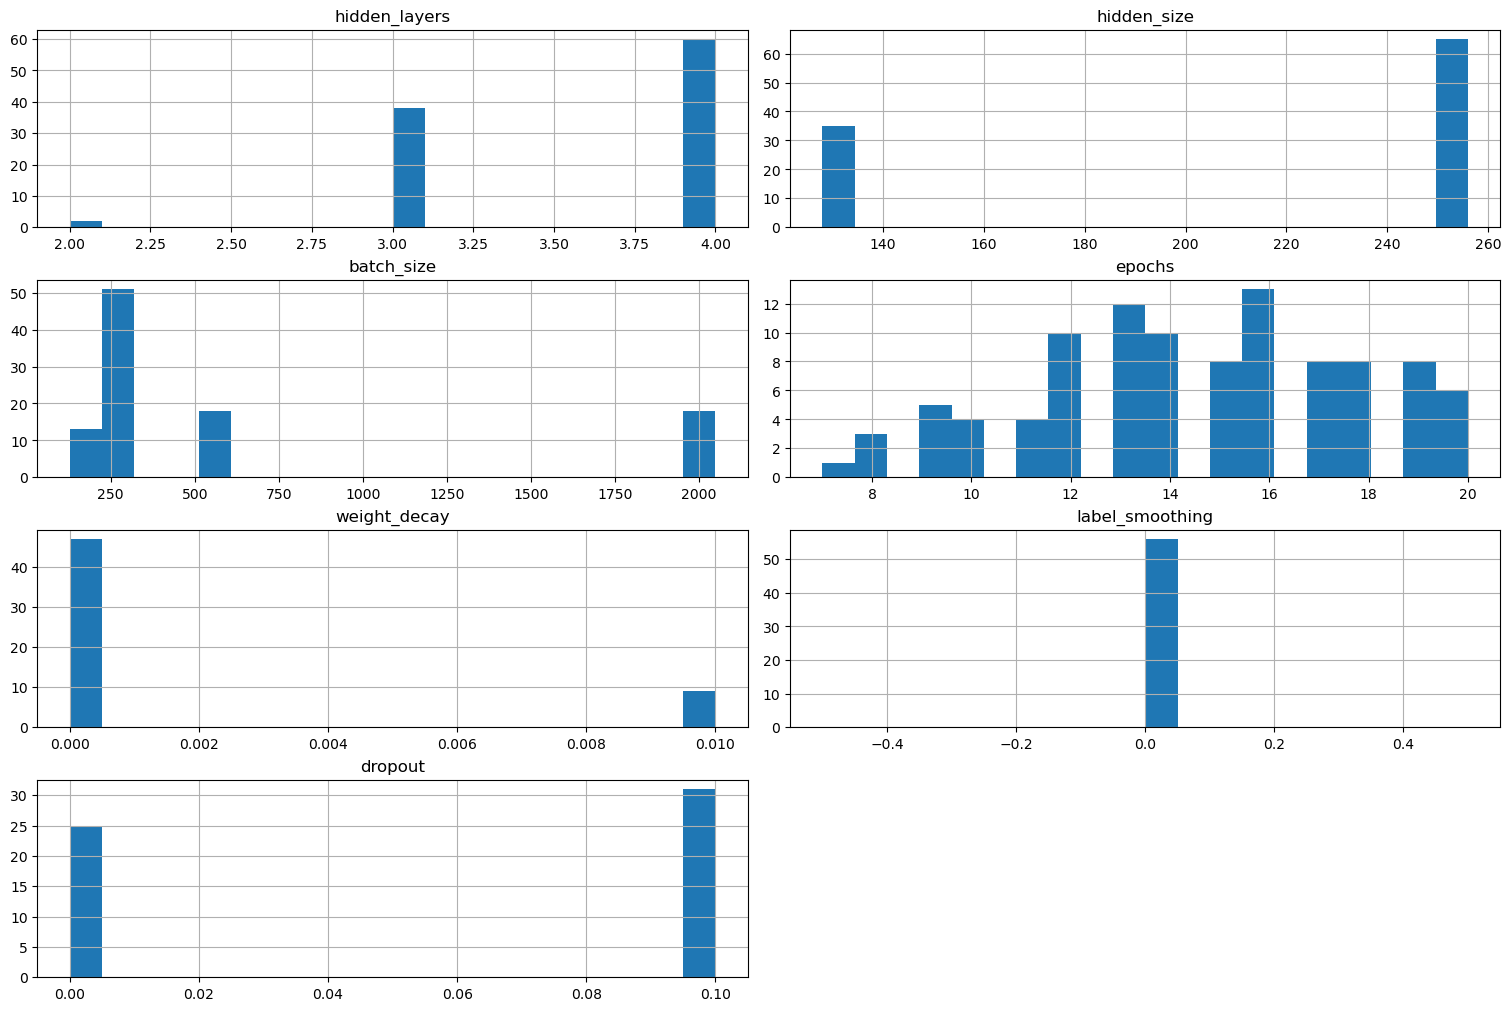

In [146]:
fig = plt.figure(figsize=(15, 10), constrained_layout=True)
params = ['hidden_layers', 'hidden_size', 'batch_size', 'epochs', 'weight_decay', 'label_smoothing', 'dropout']
for i, param in enumerate(params):
    ax = fig.add_subplot(4, 2, i + 1)
    df_ffnn_overall_top[param].hist(ax=ax, bins=20)
    ax.set_title(param)

plt.show()

Before considering analysis of this data, lets first find out how many models are there with regularization and how many without regularization:

In [148]:
with_regularization = len(df_results[df_results['tag'] == 'ffnn_regularization'])
without_regularization = len(df_results) - with_regularization
print(f"With regularization: {with_regularization}")
print(f"Without regularization: {without_regularization}")

With regularization: 1660
Without regularization: 1615


Proportions are almost the same, thus we can assume there will be no data imbalance looking upon the upper histograms. 
But still we should remember that regularization was done on best hyperparameters from non-regularization experiments.

Best models have:
- some weight decay
- some dropout


### Optimizers experiments

Because in previous section best models have:
- some weight decay
- some dropout

We will try to train models with weight decay and dropout, but with other hyperparameters taken from the best models with regularization and without plus we will experiment optimizers: 
- Adam
- SGD

In [163]:
hparams = {
    "hidden_size": [256],
    "hidden_layers": [4],
    "epochs": [30],
    "batch_size": [256, 2048],  # 2048 because it has the best model overall
    "weight_decay": [0.0, 1e-4, 1e-3, 1e-2],
    "dropout": [0.0, 0.1, 0.2, 0.3],
    "optimizer": ["Adam", "SGD"]
}
hparams_grid = ParameterGrid(hparams)
print("Hyperparameter space size: ", len(hparams_grid))

Hyperparameter space size:  64


In [164]:
for params in tqdm(hparams_grid, total=len(hparams_grid)):
    csv_exporter = CSVExporter(list(hparams.keys()))
    train(NeuralNetwork, train_data, val_data, tag="ffnn_optimizers", disable_output=True,
          print_summary=False, csv_exporter=csv_exporter, **params)
    csv_exporter.save()

100%|██████████| 64/64 [46:50<00:00, 43.91s/it] 


Both Adam and SGD:

![](images/ffnn_optimizers/all.png)

SGD only:

![](images/ffnn_optimizers/all_sgd.png)

Adam only:

![](images/ffnn_optimizers/all_adam.png)

We see that SGD performs much worse than Adam, which is something expected, because SGD is a more simple algorithm than Adam.

What is very interesting are spikes with SGD optimizer:

![](images/ffnn_optimizers/SGD_spikes.png)

Dropout is 0.0 in both groups - spiky and nom-spiky. The only difference between spiky and non-spiky is batch-size - in spiky it is 256, in non-spiky 2048. This is very interesting, because first impression may be that the absence of dropout caused spikes, but the second non-spiky group, which is without dropout too, is smooth. One of the reasons may be that the model just gets into some special parameter landscape, where with SGD it bounces back and forth in some kind of "ravine". 

Now, let's find out the best model - model with the least validation loss:

In [168]:
df_results = pd.read_csv("logs/results.csv")
best_model_index = df_results['val_loss'].idxmin()
df_results.loc[best_model_index]

log_name           2024-05-13_19:28:57_bs=2048,d=0.1,e=30,hl=4,hs...
tag                                                  ffnn_optimizers
hidden_size                                                      256
hidden_layers                                                      4
epochs                                                            24
batch_size                                                      2048
train_loss                                                   0.39997
train_acc                                                   0.854159
val_loss                                                    0.435735
val_acc                                                     0.841286
weight_decay                                                    0.01
label_smoothing                                                  NaN
dropout                                                          0.1
optimizer                                                       Adam
Name: 4593, dtype: object

### Normalization/Standardization experiments

How we will try normalization and standardization. 

Normalization and standardization techniques are very useful when we have model that uses distance metrics and data are not scaled identically, so some features can dominate over the others.

But in our case pixels have the same scale, so standardization or normalization may have no significant impact on our model. 
But for the sake of exploration and curiosity, we will try normalization and standardization and also play a little bit around the best model's hyperparameters:

In [187]:
def prepare_torch_dataset(X_train, y_train, X_val, y_val, normalization="none"):
    scaler = None
    if normalization == "minmax":
        scaler = MinMaxScaler()
    elif normalization == "standardization":
        scaler = StandardScaler()

    if scaler:
        X_train_transformed = scaler.fit_transform(X_train)
        X_val_transformed = scaler.transform(X_val)
    else:
        X_train_transformed = X_train.to_numpy()
        X_val_transformed = X_val.to_numpy()

    train_data = torch.utils.data.TensorDataset(torch.tensor(X_train_transformed, dtype=torch.float32),
                                                torch.tensor(y_train.to_numpy()))
    val_data = torch.utils.data.TensorDataset(torch.tensor(X_val_transformed, dtype=torch.float32),
                                              torch.tensor(y_val.to_numpy()))

    return train_data, val_data

In [188]:
hparams = {
    "hidden_size": [128, 256],
    "hidden_layers": [3, 4],
    "epochs": [30],
    "batch_size": [2048],
    "weight_decay": [1e-2, 1e-1],
    "dropout": [0.1, 0.2],
    "optimizer": ["Adam"],
    "label_smoothing": [0.0],
    "normalization": ["none", "minmax", "standardization"]
}

hparams_grid = ParameterGrid(hparams)
print("Hyperparameter space size: ", len(hparams_grid))

Hyperparameter space size:  48


In [189]:
for params in tqdm(hparams_grid, total=len(hparams_grid)):
    train_data, val_data = prepare_torch_dataset(X_train, y_train, X_val, y_val, normalization=params['normalization'])
    csv_exporter = CSVExporter(list(hparams.keys()))
    train(NeuralNetwork, train_data, val_data, tag="ffnn_normalization", disable_output=True,
          print_summary=False, csv_exporter=csv_exporter, **params)
    csv_exporter.save()

100%|██████████| 48/48 [28:07<00:00, 35.15s/it]


Without normalization:
![](images/ffnn_normalization/all_none.png)

MinMax normalization:

![](images/ffnn_normalization/all_minmax.png)

Standardization:

![](images/ffnn_normalization/all_standardization.png)

Though we expected that normalization will not have significant impact, clearly we see, that normalization has negative effect. Reasons why it is that may be different, for example numerical, with ReLu activation function, or more probably with weight decay.

Let's test if weight decay somehow creates this issue:

In [192]:
hparams = {
    "hidden_size": [256],
    "hidden_layers": [4],
    "epochs": [30],
    "batch_size": [2048],
    "weight_decay": [0.0, 1e-1, 1e-2, 1e-3],
    "dropout": [0.1],
    "optimizer": ["Adam"],
    "label_smoothing": [0.0],
    "normalization": ["none", "minmax", "standardization"]
}

hparams_grid = ParameterGrid(hparams)
print("Hyperparameter space size: ", len(hparams_grid))

Hyperparameter space size:  12


In [193]:
for params in tqdm(hparams_grid, total=len(hparams_grid)):
    train_data, val_data = prepare_torch_dataset(X_train, y_train, X_val, y_val, normalization=params['normalization'])
    csv_exporter = CSVExporter(list(hparams.keys()))
    train(NeuralNetwork, train_data, val_data, tag="ffnn_normalization/weight_decay_test", disable_output=True,
          print_summary=False, csv_exporter=csv_exporter, **params)
    csv_exporter.save()

100%|██████████| 12/12 [08:35<00:00, 42.93s/it]


weight decay = 0.0:

![](images/ffnn_normalization/weight_decay_test/all_no_wd.png)

weight_decay = 0.1:

![](images/ffnn_normalization/weight_decay_test/all_wd_0.1.png)

This is very interesting, we see that with normalization the weight decay = 0.1 significantly affects loss and accuracy, while without normalization the scores are not affected so significantly.

# Convolutional Neural Network

TODO

In [ ]:
# TODO

# Evaluation

TODO

In [ ]:
# TODO